In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import tqdm
import mat4py
from sklearn import metrics
import logomaker
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import seqlogo
import scipy
import re
from matplotlib import gridspec
import scipy
from sklearn.metrics import auc, average_precision_score
from collections import OrderedDict
import os
%matplotlib notebook

In [21]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [20]:
def kc_motif_distance(trimed_true_dimer, trimed_pred_dimer):
    t = matlab.double(trimed_true_dimer.tolist())
    p = matlab.double(trimed_pred_dimer.tolist())
    prof = np.asarray(eng.profalign(p, t)).T
    t = np.asarray(t).T
    p = np.asarray(p).T
    # print(prof)
    # print(p)
    # print(t)
    add_mat = prof[:,:4]
    gap_locus = prof[:,4]
    # print(t.shape, p.shape, add_mat.shape)
    # print(gap_locus)
    total_dist = 0
    max_dist = -1
    t_gap = 0
    p_gap = 0
    for i, lo in enumerate(gap_locus):
        if lo == 0:
            dist = np.sqrt(sum((p[i-p_gap]-t[i-t_gap])**2))
            total_dist += dist
            if dist > max_dist:
                max_dist = dist
        else:
            if i-t_gap >= len(t):
                t_gap += 1
            elif i-p_gap >= len(p):
                p_gap += 1
            elif sum(abs(add_mat[i] - t[i-t_gap])) < sum(abs(add_mat[i] - p[i-p_gap])):
                p_gap += 1
            else:
                t_gap += 1
        # print(max_dist, "p_gap:", p_gap, "t_gap:", t_gap)
    return (total_dist + (p_gap+t_gap)*max_dist)/len(gap_locus)

In [6]:
deepSyn_df = pd.read_csv("./data/leave_one_mp_crxvalid_deepSyn.csv")
motifKirin_df = pd.read_csv("./data/kc_530dimer_AssumeGivenAlignment_motif_distance_corrected.csv")

In [8]:
inkc_df = deepSyn_df[deepSyn_df['kc_selected']].merge(motifKirin_df[['Dimer Name', 'motif_distance', 'deepSyn_motif_distance']], how='left', left_on='dimer_name', right_on='Dimer Name')

In [12]:
inkc_df['diff'] = inkc_df['motif_distance'] - inkc_df['deepSyn_mmd']
fam_group_df = inkc_df.groupby(by='family_name').mean()
fam_group_df = fam_group_df.sort_values(by='diff', ascending=False)
noinKC_df = deepSyn_df[~deepSyn_df['kc_selected']]

<IPython.core.display.Javascript object>


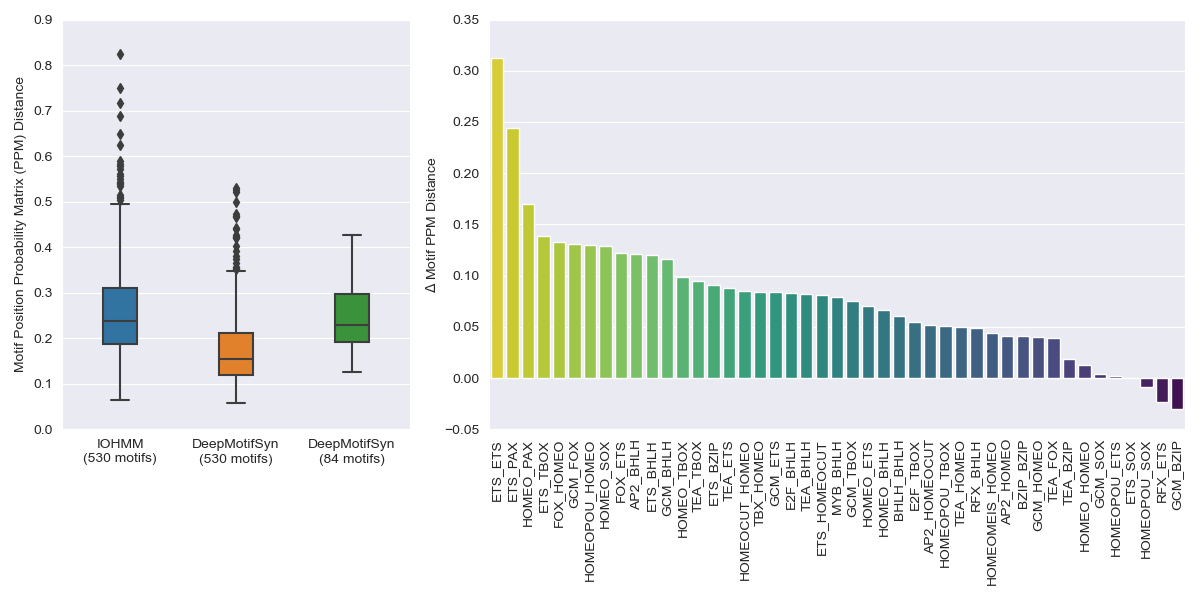

In [14]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 4]) 
ax0 = plt.subplot(gs[0])
sns.boxplot(y=list(inkc_df["motif_distance"]) + list(inkc_df['deepSyn_mmd']) + list(noinKC_df['deepSyn_mmd']), x = ['IOHMM\n(530 motifs)']*len(inkc_df) + ['DeepMotifSyn\n(530 motifs)']*len(inkc_df) + ['DeepMotifSyn\n(84 motifs)']*len(noinKC_df), width=0.3)
plt.ylabel('Motif Position Probability Matrix (PPM) Distance')
plt.ylim(0, 0.9)
ax1 = plt.subplot(gs[1])
sns.barplot(ax=ax1, x = fam_group_df.index, y=fam_group_df['diff'],palette=("viridis_r"))
plt.xticks(rotation=90)
plt.ylim(-0.05, 0.35)
plt.ylabel("${\Delta}$ Motif PPM Distance")
plt.xlabel("")
plt.tight_layout()

#  End-to-end heterodimeric motif synthesis

In [28]:
xgboost_df = pd.read_csv("./data/generated_motifpairs_with_label_rmDuplicates_xgboostPred_correctedFam.csv")
found_mp_name, found_mp_family, _, true_mp_code, found_mp_dimer_code = pkl.load(open("../data/found_best_aligned_mp_allFam_correctedFamilyName.pkl", "rb"))
pred_dimer_whole_loMPo = np.load("../data/deeper_uNet_loMPo_predictive_all_possible_alignedMP_dedup.npy")
kc_selected_dimer = list(motifKirin_df['Dimer Name'])

## Performance of XGBoost under leave-one-motif-pair-out cross-validation

<IPython.core.display.Javascript object>


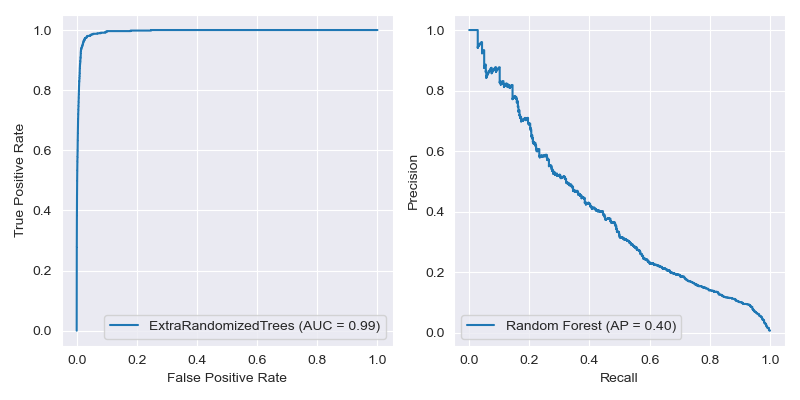

ROC-ROC: 0.9942433943551623
PR-AUC: 0.39718671823978163


In [69]:
generated_motif_df = xgboost_df
labels = generated_motif_df['label']>0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fpr, tpr, thresholds_roc = metrics.roc_curve(labels, generated_motif_df['xgboost_prediction'])
prec, recall, thresholds_prc = metrics.precision_recall_curve(labels, generated_motif_df['xgboost_prediction'])
print("ROC-ROC:", auc(fpr, tpr))
print("PR-AUC:", average_precision_score(labels, generated_motif_df['xgboost_prediction']))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name='ExtraRandomizedTrees').plot(ax=ax1)
PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision_score(labels, generated_motif_df['xgboost_prediction']), estimator_name='Random Forest').plot(ax=ax2)
plt.tight_layout()

# Get top 10 predicted heterodimeric motif of each motif pair and compute motif PPM distance

In [29]:
topN = 10
n_found_dimers = 0
total_dimers = 0
matched_pred_dict = {}
mmd_dict = {}
kc_mmd_dict = {}
noKc_mmd_dict = {}

for mp_name in tqdm.tqdm(set(xgboost_df['mp_name'])):
    tdf = xgboost_df[xgboost_df['mp_name'] == mp_name]
    tdf = tdf.sort_values(by='xgboost_prediction', ascending=False)
    true_dimers = []
    for td in tdf[~tdf['match_true_dimer'].isna()]['match_true_dimer']:
        true_dimers += td.split(",")
    total_dimers+=len(true_dimers)
    # topN = len(true_dimers)
    n_found_dimers+=sum(tdf.iloc[:topN]['label'])

    for tdimer in true_dimers:
        true_dimer_code = found_mp_dimer_code[found_mp_name == tdimer][0].T
        best_mmd = np.inf
        best_idx = None
        for idx, row in tdf.iloc[:topN].iterrows():
            pred_dimer_code = pred_dimer_whole_loMPo[idx]
            true_dimer_len = len(true_dimer_code[0][true_dimer_code[0] != -1])
            trimed_true_dimer = true_dimer_code[:, :true_dimer_len]
            trimed_pred_dimer = pred_dimer_code[:, :true_dimer_len]
            try:
                mmd = kc_motif_distance(trimed_true_dimer, trimed_pred_dimer)
            except:
                print(tdimer, idx)
                continue
            if mmd < best_mmd:
                best_mmd = mmd
                matched_pred_dict[tdimer] = [trimed_pred_dimer, trimed_true_dimer]
                mmd_dict[tdimer] = mmd
                best_idx = idx
            
        xgboost_df.loc[best_idx, 'matched_with'] = tdimer
        
        if tdimer in kc_selected_dimer:
            kc_mmd_dict[tdimer] = mmd_dict[tdimer]
        else:
            noKc_mmd_dict[tdimer] = mmd_dict[tdimer]

100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


## Motif PPM Distance of 530 heterodimeric motif

In [33]:
"Mean:", np.mean(list(kc_mmd_dict.values())), "Std:", np.std(list(kc_mmd_dict.values())), "Number of Motifs:", len(kc_mmd_dict)

('Mean:',
 0.25728933978896185,
 'Std:',
 0.09627051877085135,
 'Number of Motifs:',
 530)

## Motif PPM Distance of 84 heterodimeric motif

In [35]:
"Mean:", np.mean(list(noKc_mmd_dict.values())), "Std:", np.std(list(noKc_mmd_dict.values())), "Number of Motifs:", len(noKc_mmd_dict)

('Mean:',
 0.2772736453013525,
 'Std:',
 0.08293142636230584,
 'Number of Motifs:',
 84)

In [40]:
motifKirin_df = pd.read_csv("./data/kc_530dimer_NoGivenAlignment_motif_distance_corrected.csv")
dnameToUpperFam = pkl.load(open("../data/dimer_name_family_upper_dict.pkl", "rb"))
for idx, row in motifKirin_df.iterrows():
    dname = row['Dimer Name']
    motifKirin_df.loc[idx, 'deepSyn_ppm_distance'] = mmd_dict[dname]
    motifKirin_df.loc[idx, 'family_upper'] = dnameToUpperFam[dname]

In [41]:
motifKirin_df['diff_distance'] = motifKirin_df['mmd'] - motifKirin_df['deepSyn_ppm_distance']

In [57]:
kirin_df = motifKirin_df[['Dimer Name', 'family_upper', 'mmd']]
deepSyn_df = motifKirin_df[['Dimer Name', 'family_upper', 'deepSyn_ppm_distance','diff_distance']]
deepSyn_df = deepSyn_df.sort_values(by='deepSyn_ppm_distance')
kirin_df['model'] = 'MotifKirin'
deepSyn_df['model'] = 'deepMotifSyn'

C:\Users\jieconlin3\Anaconda3\envs\motif_synthesis_py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [61]:
sns.set_style('darkgrid')
ax = plt.figure(figsize=(14,6))
ax = sns.boxplot(x=list(deepSyn_df['family_upper'])+list(kirin_df['family_upper']), y=list(deepSyn_df['deepSyn_ppm_distance'])+list(kirin_df['mmd']) , hue=['DeepMotifSyn']*len(deepSyn_df)+['MotifKirin']*len(kirin_df), palette="Set3")
plt.xticks(rotation=90)
plt.ylabel("Motif Position Frequency Matrix (PFM) Distance")
plt.tight_layout()

<IPython.core.display.Javascript object>